In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [2]:
def get_framerate_and_fourcc(iFilePath):
    vVideoCapture = cv2.VideoCapture(iFilePath)
    vFrameRate = vVideoCapture.get(cv2.CAP_PROP_FPS)
    vFourcc = int(vVideoCapture.get(cv2.CAP_PROP_FOURCC))
    vVideoCapture.release()

    return vFrameRate, vFourcc

In [3]:
cVIDEO_FILE = "../resources/video/videoplayback.mp4"
cVIDEO_FILE_BOXES = "../resources/video/video_boxes.mp4"

gFrameRate, gFourcc = get_framerate_and_fourcc(cVIDEO_FILE)

In [5]:
def get_frames(iFilePath):
    vVideoCapture = cv2.VideoCapture(iFilePath)
    vSucces, vFrame = vVideoCapture.read()
    vIndex = 0
    vFrames = list()
    while vSucces:
        vFrame = cv2.cvtColor(vFrame, cv2.COLOR_BGR2RGB)
        vFrames.append({
            "frame_index": vIndex,
            "original_image": Image.fromarray(vFrame)
        })

        vSucces, vFrame = vVideoCapture.read()
        vIndex = vIndex + 1
    return vFrames

gFrames = get_frames(cVIDEO_FILE)

In [9]:

def get_mse_between_frames(iImagePrevious, iImageCurrent):
    vImagePrevious = np.array(iImagePrevious).astype(np.float32)
    vImageCurrent  = np.array(iImageCurrent).astype(np.float32)
    
    vSquaredError = (vImageCurrent - vImagePrevious) ** 2
    vNormalizedError = (vSquaredError - vSquaredError.min()) / (vSquaredError.max() - vSquaredError.min()) * 255
    #vReducedError = cv2.resize(vSquaredError, (8, 8), interpolation = cv2.INTER_AREA)
    vGrayError = (vNormalizedError[:, :, 0] + vNormalizedError[:, :, 1] + vNormalizedError[:, :, 2])
    vGrayError = vGrayError.astype(np.uint8)
    vMSE = np.mean(vGrayError)
    return vMSE, vGrayError

tPreviousFrame = gFrames[0]["original_image"]
for tFrame in gFrames:
    print("\rProcessing frame:", tFrame["frame_index"], end="")
    tImage = tFrame["original_image"]
    tFrame["mse"], tFrame["mse_image"] = get_mse_between_frames(tPreviousFrame, tImage)
    tPreviousFrame = tImage

Processing frame: 18

C:\Users\Johan\AppData\Local\Temp\ipykernel_5976\736702769.py:6: RuntimeWarning: invalid value encountered in divide
  vNormalizedError = (vSquaredError - vSquaredError.min()) / (vSquaredError.max() - vSquaredError.min()) * 255
C:\Users\Johan\AppData\Local\Temp\ipykernel_5976\736702769.py:9: RuntimeWarning: invalid value encountered in cast
  vGrayError = vGrayError.astype(np.uint8)


Processing frame: 1879

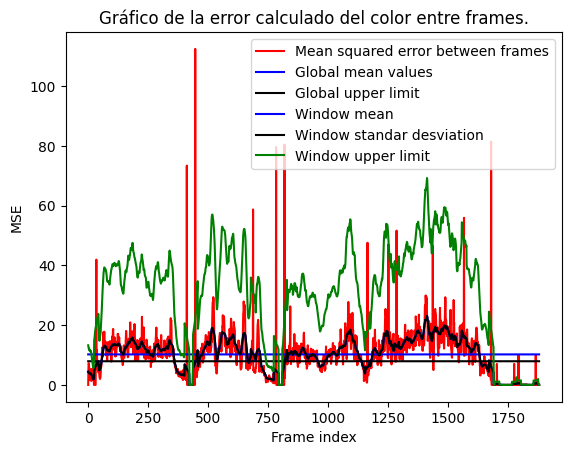

In [123]:
gMSE = [x["mse"] for x in gFrames]
gMSE = np.array(gMSE)
gMSE = [(x, np.mean(gMSE), np.std(gMSE, ddof=1), np.mean(gMSE) + 2 * np.std(gMSE, ddof=1)) for x in gMSE ]

vWindowSize = 10
gResult = []
# Calcular la media y la desviación estándar para cada ventana de 10 registros adyacentes
for i in range(0, len(gMSE)):
    vStartWindow = i - vWindowSize
    if vStartWindow < 0:
        vStartWindow = 0
    vWindow = gMSE[vStartWindow : i + vWindowSize]
    vWindow = [x[0] for x in vWindow]
    tMean = np.mean(vWindow)
    tStdDev = np.mean(vWindow)
    gResult.append((tMean, tStdDev, tMean + 2*tStdDev))

gFrameIndex    = [i for i, x in enumerate(gMSE)]
tRawValues     = [x[0] for x in gMSE]
tMeanValues    = [x[1] for x in gMSE]
t2StdDevValues = [x[2] for x in gMSE]
tMeanWindow    = [x[0] for x in gResult]
tStdDevWindow  = [x[1] for x in gResult]
t2StdDevWindow = [x[2] for x in gResult]

fig, ax = plt.subplots()
ax.plot(gFrameIndex, tRawValues, label = "Mean squared error between frames", color = "red")
ax.plot(gFrameIndex, tMeanValues, label = "Global mean values", color = "blue")
ax.plot(gFrameIndex, t2StdDevValues, label = "Global upper limit", color = "black")
ax.plot(gFrameIndex, tMeanWindow, label = "Window mean", color = "blue")
ax.plot(gFrameIndex, tStdDevWindow, label = "Window standar desviation", color = "black")
ax.plot(gFrameIndex, t2StdDevWindow, label = "Window upper limit", color = "green")
ax.set_xlabel("Frame index")
ax.set_ylabel("MSE")
ax.set_title("Gráfico de la error calculado del color entre frames.")
ax.legend()
plt.show()

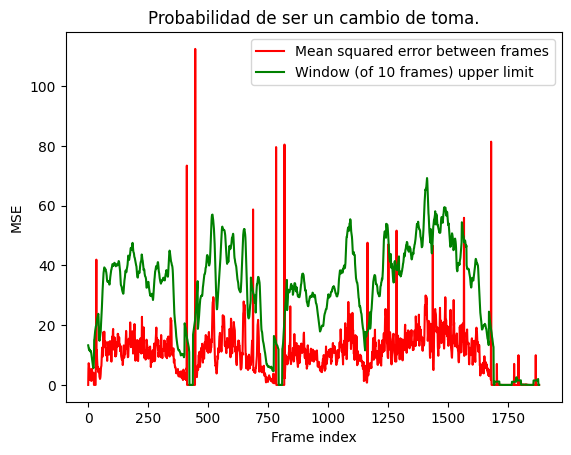

In [124]:
fig, ax = plt.subplots()
ax.plot(gFrameIndex, tRawValues, label = "Mean squared error between frames", color = "red")
#ax.plot(gFrameIndex, tMeanValues, label = "Global mean values", color = "blue")
#ax.plot(gFrameIndex, t2StdDevValues, label = "Global upper limit", color = "black")
#ax.plot(gFrameIndex, tMeanWindow, label = "Window mean", color = "blue")
#ax.plot(gFrameIndex, tStdDevWindow, label = "Window standar desviation", color = "black")
ax.plot(gFrameIndex, t2StdDevWindow, label = "Window (of 10 frames) upper limit", color = "green")
ax.set_xlabel("Frame index")
ax.set_ylabel("MSE")
ax.set_title("Probabilidad de ser un cambio de toma.")
ax.legend()
plt.show()
# Se observa que el la media más dos veces la desviación estandar del error de color de una ventana de 10 frames
# puede ayudar a saber cuando hay un cambio entre tomas.

Frame:  33


<Figure size 500x500 with 0 Axes>

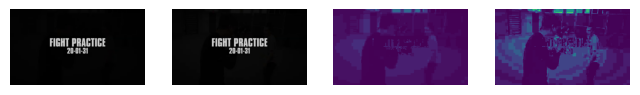

Frame:  34


<Figure size 500x500 with 0 Axes>

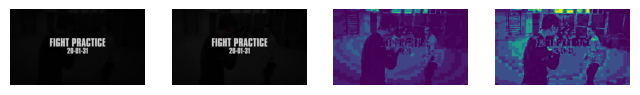

Frame:  411


<Figure size 500x500 with 0 Axes>

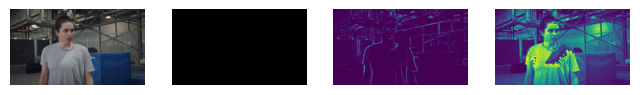

Frame:  446


<Figure size 500x500 with 0 Axes>

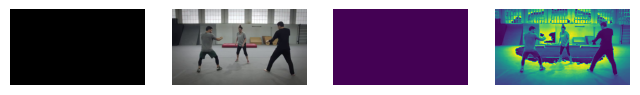

Frame:  687


<Figure size 500x500 with 0 Axes>

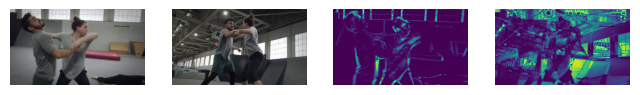

Frame:  783


<Figure size 500x500 with 0 Axes>

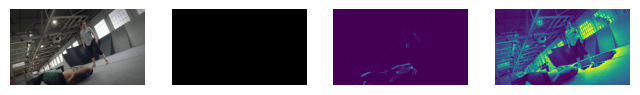

Frame:  818


<Figure size 500x500 with 0 Axes>

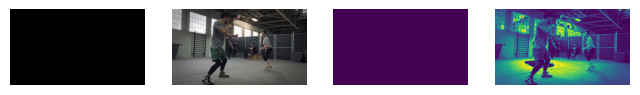

Frame:  1164


<Figure size 500x500 with 0 Axes>

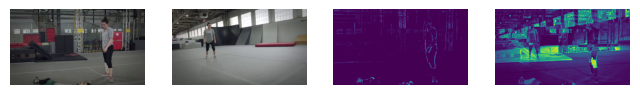

Frame:  1285


<Figure size 500x500 with 0 Axes>

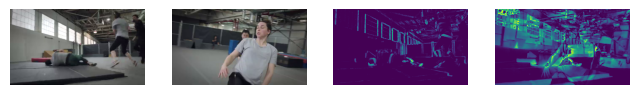

Frame:  1566


<Figure size 500x500 with 0 Axes>

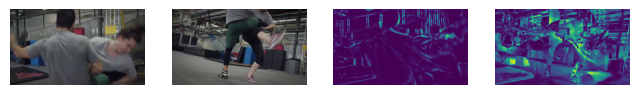

Frame:  1679


<Figure size 500x500 with 0 Axes>

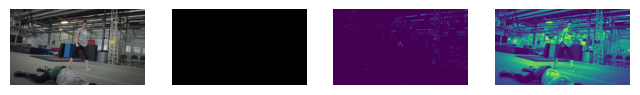

Frame:  1703


<Figure size 500x500 with 0 Axes>

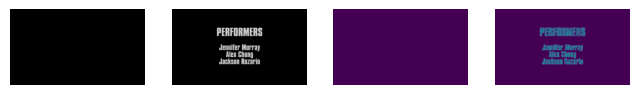

Frame:  1775


<Figure size 500x500 with 0 Axes>

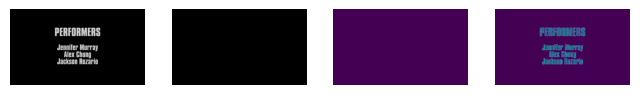

Frame:  1793


<Figure size 500x500 with 0 Axes>

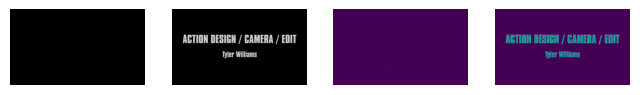

Frame:  1811


<Figure size 500x500 with 0 Axes>

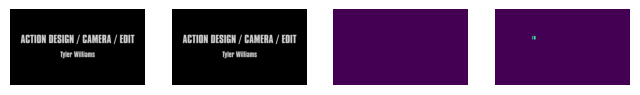

Frame:  1812


<Figure size 500x500 with 0 Axes>

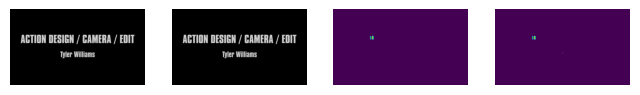

Frame:  1821


<Figure size 500x500 with 0 Axes>

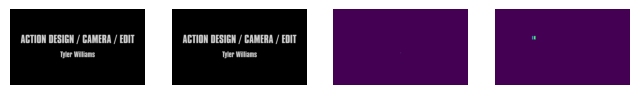

Frame:  1827


<Figure size 500x500 with 0 Axes>

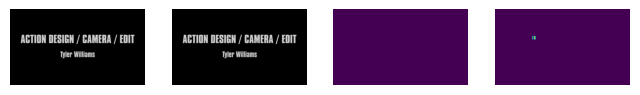

Frame:  1865


<Figure size 500x500 with 0 Axes>

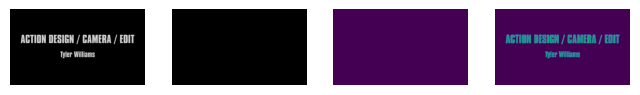

In [141]:
gMSE_Window = [y[2] - x[0] for x, y in zip(gMSE, gResult)]

gChangeBetweenFrames = [ x for x in enumerate(gMSE_Window) if x[1] < 0 ]
gChangeBetweenFrames

for tFrameIndex, tScore in gChangeBetweenFrames:
    print("Frame: ", tFrameIndex)
    plt.figure(figsize = (5, 5))
    _, vAxisArray = plt.subplots(1, 4, figsize = (8, 8))
    vAxisArray[0].imshow(gFrames[tFrameIndex - 1]["original_image"])
    vAxisArray[0].axis('off')
    vAxisArray[1].imshow(gFrames[tFrameIndex]["original_image"])
    vAxisArray[1].axis('off')
    vAxisArray[2].imshow(gFrames[tFrameIndex - 1]["mse_image"])
    vAxisArray[2].axis('off')
    vAxisArray[3].imshow(gFrames[tFrameIndex]["mse_image"])
    vAxisArray[3].axis('off')
    plt.show()

In [153]:
def save_frames2video(iFilePath, iListImages, iFrameRate, iShape):
    vVideoWriter = cv2.VideoWriter(
        iFilePath,
        cv2.VideoWriter_fourcc(*'MP4V'),
        iFrameRate,
        iShape
    )

    try:
        for i, tFrame in enumerate(iListImages):
            print("\rProcessing frame", i, end = "")
            tFrame = cv2.cvtColor(tFrame, cv2.COLOR_RGB2BGR)
            vVideoWriter.write(tFrame)
    finally:
        vVideoWriter.release()

vFrames2Save = [x["mse_image"] for x in gFrames]
#save_frames2video("../resources/video/video_mse_gray.mp4", vFrames2Save, gFrameRate, vFrames2Save[0].shape[::-1])

vFrames2Save = [cv2.applyColorMap(x, cv2.COLORMAP_JET) for x in vFrames2Save]
vFrames2Save = [cv2.cvtColor(x, cv2.COLOR_RGB2BGR) for x in vFrames2Save]
save_frames2video("../resources/video/video_mse_colormap.mp4", vFrames2Save, gFrameRate, vFrames2Save[0].shape[:2][::-1])

Processing frame 1879